Generate from a gamma
Individual PCA, correlate with globak PCA, corr to 1, subjects closer 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import os.path as op
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import sample
import xarray as xr
import pyhsmm_mvpa as hsmm
import seaborn as sns
import pandas as pd


In [2]:
n_events = 500
sources = [['lateraloccipital-lh',1e-8, [200,20]],
           ['lateraloccipital-rh',1e-8, [300,20]],
           ['postcentral-lh', 1e-8, [250,20]],
           ['postcentral-rh', 1e-8, [250,20]],
           ['postcentral-lh', 1e-25, [100,20]]]#Response trigger, amplitude scale make it hardly visible for hsmm

max_trial_length = 3000#ms

bump_frequency = 10.

if 'simulated-raw.fif' in os.listdir():
    raw = mne.io.read_raw_fif('simulated-raw.fif')
    generating_events = np.load('generating_events.npy')
else:
    # Following code and comments largely comes from MNE examples (e.g. https://mne.tools/stable/auto_examples/simulation/simulated_raw_data_using_subject_anatomy.html)
    # For this example, we will be using the information of the sample subject.
    # This will download the data if it not already on your machine. We also set
    # the subjects directory so we don't need to give it to functions.
    data_path = sample.data_path()
    subjects_dir = op.join(data_path, 'subjects')
    subject = 'sample'

    # First, we get an info structure from the test subject.
    evoked_fname = op.join(data_path, 'MEG', subject, 'sample_audvis-ave.fif')
    info = mne.io.read_info(evoked_fname)
    tstep = 1. / info['sfreq']

    # To simulate sources, we also need a source space. It can be obtained from the
    # forward solution of the sample subject.
    fwd_fname = op.join(data_path, 'MEG', subject,
                        'sample_audvis-meg-eeg-oct-6-fwd.fif')
    fwd = mne.read_forward_solution(fwd_fname)
    #fwd = fwd.pick_channels(info.ch_names[-61:])
    src = fwd['src']

    source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep, first_samp=0, duration=(2+1*n_events+3)*max_trial_length*tstep)

    # stim_onset occurs every x samples.
    events = np.zeros((n_events, 3), int)
    stim_onsets =  2000+max_trial_length * np.arange(n_events)#2000 = offset of first stim
    events[:,0] = stim_onsets#last event 
    
    trigger = 1
    random_source_times = []
    generating_events = events
    for source in sources:
        selected_label = mne.read_labels_from_annot(
            subject, regexp=source[0], subjects_dir=subjects_dir)[0]
        label = mne.label.select_sources(
            subject, selected_label, location='center', extent=10,# Extent in mm of the region.
            subjects_dir=subjects_dir)

        # Define the time course of the activity for each source of the region to
        # activate.
        source_time_series = np.sin(2. * np.pi * bump_frequency * np.arange(25) * tstep) * source[1]

    
        #adding source event
        events = events.copy()
        random_source_times.append(np.random.normal(source[2][0],source[2][1],n_events)) #varying event 
        events[:, 0] = events[:,0] + random_source_times[-1] # Events sample.
        events[:, 2] = trigger  # All events have the sample id.
        trigger += 1
        generating_events = np.concatenate([generating_events, events])

        #add these events
        source_simulator.add_data(label, source_time_series, events)
 
    generating_events = generating_events[generating_events[:, 0].argsort()]
    # Project the source time series to sensor space and add some noise. The source
    # simulator can be given directly to the simulate_raw function.
    raw = mne.simulation.simulate_raw(info, source_simulator, forward=fwd, n_jobs=16,verbose=False)
    cov = mne.make_ad_hoc_cov(raw.info)
    mne.simulation.add_noise(raw, cov, iir_filter=[0.2, -0.2, 0.04])
    #raw.plot()

    raw.save('simulated-raw.fif',overwrite=True)
    np.save('generating_events.npy', generating_events)

    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading forward solution from /home/gweindel/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    MEG and EEG forward solutions combined
    Source spaces transformed to the forward solution coordinate frame
Reading labels fro

In [4]:
number_of_sources = len(np.unique(generating_events[:,2])[1:])
random_source_times = np.zeros((int(len(generating_events)/(number_of_sources+1)), number_of_sources))

resp_trigger = int(np.max(np.unique(generating_events[:,2])))

i,x = 1,0                  
while x <len(random_source_times):
    for j in np.arange(number_of_sources):
        random_source_times[x,j] = generating_events[i,0] - generating_events[i-1,0]
        i += 1
    i += 1
    x += 1

events = generating_events[(generating_events[:,2] == 0) | (generating_events[:,2] == resp_trigger)]

event_id = {'stimulus':0}
resp_id = {'response':resp_trigger}
eeg_dat = hsmm.read_mne_EEG(['simulated-raw.fif'], event_id, resp_id, raw.info['sfreq'],events)
hsmm_dat, PCs = hsmm.transform_data(eeg_dat.data,'',
        apply_standard=False,single=True, return_weights=True, n_comp=3)
hsmm_dat = hsmm.stack_data(hsmm_dat,'',single=True)
init = hsmm.hsmm(hsmm_dat.data.T[:,:,0], hsmm_dat.starts.data, 
                 hsmm_dat.ends.data, sf=eeg_dat.sfreq, bump_width=50, cpus=5)

Reading 0 ... 1514999  =      0.000 ...  2522.413 secs...
Adding metadata with 2 columns
500 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
4 projection items activated
Using data from preloaded Raw for 500 events and 1442 original time points ...
0 bad epochs dropped


In [5]:
hsmm_dat

<xarray.Dataset>
Dimensions:      (component: 3, all_samples: 541960, participant: 1, trial: 493)
Coordinates:
  * component    (component) int64 0 1 2
  * all_samples  (all_samples) MultiIndex
  - epochs       (all_samples) int64 0 0 0 0 0 0 0 ... 492 492 492 492 492 492
  - samples      (all_samples) int64 0 1 2 3 4 5 ... 1160 1161 1162 1163 1164
  * trial        (trial) int64 0 1 2 3 4 5 6 7 ... 486 487 488 489 490 491 492
Dimensions without coordinates: participant
Data variables:
    data         (participant, component, all_samples) float64 0.1734 ... 0.6613
    starts       (trial) int64 0 1124 2228 3302 ... 537450 538531 539646 540795
    ends         (trial) int64 1123 2227 3301 4397 ... 539645 540794 541959

# Estimating a 4 bump model

Estimating parameters for 4 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 4 bumps model


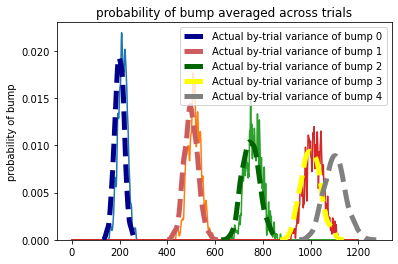

<xarray.DataArray 'parameters' (stage: 5)>
array([0.4053215 , 0.53240068, 0.22442229, 0.1459571 , 0.28555361])
Dimensions without coordinates: stage


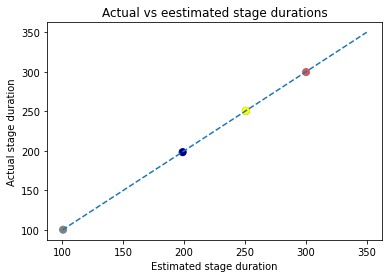

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


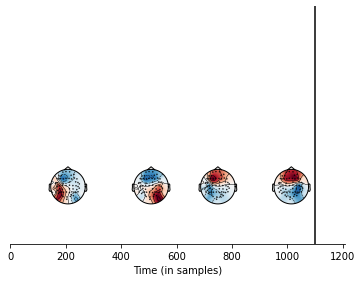

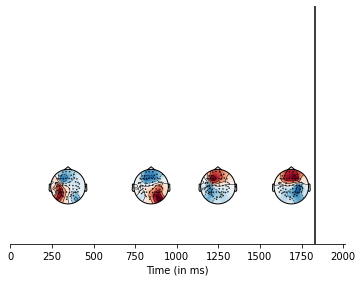

In [7]:
estimates = init.fit_single(4)

plt.plot(estimates.eventprobs.mean(dim=['trial']));
colors = ['darkblue','indianred','darkgreen','yellow','grey']
for i in range(len(random_source_times.T)):
    sns.kdeplot(np.sum(random_source_times[:,:i+1],axis=1),lw=5, color=colors[i]
                ,ls='--',label=f'Actual by-trial variance of bump {i}')
plt.legend()
plt.title('probability of bump averaged across trials')
plt.ylabel('probability of bump')
plt.show()

print(np.mean(random_source_times, axis=0)- estimates.parameters.dropna('stage').isel(params=1)*2)
plt.scatter(np.mean(random_source_times, axis=0), estimates.parameters.dropna('stage').isel(params=1)*2, color=colors,s=50)
plt.plot([100,350], [100,350],'--');
plt.title('Actual vs eestimated stage durations')
plt.xlabel('Estimated stage duration')
plt.ylabel('Actual stage duration')
plt.show()

hsmm.plot_topo_timecourse(init, hsmm_dat, PCs, estimates, raw, magnify=5)
hsmm.plot_topo_timecourse(init, hsmm_dat, PCs, estimates, raw, time=True,magnify=5)

## Iterative estimates

### Forward method

In [8]:
import multiprocessing

cpus = multiprocessing.cpu_count()

with multiprocessing.Pool(processes=cpus) as pool:
    iterative_results = pool.map(init.fit_single, np.arange(1,init.max_bumps+1))
iterative_results = xr.concat(iterative_results,  pd.Series(np.arange(1,init.max_bumps+1), name='n_bumps'))


Estimating parameters for 1 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 2 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 3 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 4 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 5 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 6 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 7 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 8 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 9 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 10 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 11 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 12 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 13 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 14 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 15 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 16 bumps model
Parameters estimated for 1 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Estimating parameters for 17 bumps model
Parameters estimated for 2 bumps model
Estimating parameters for 18 bumps model
Parameters estimated for 3 bumps model
Estimating parameters for 19 bumps model
Parameters estimated for 4 bumps model
Estimating parameters for 20 bumps model
Parameters estimated for 5 bumps model
Estimating parameters for 21 bumps model
Parameters estimated for 6 bumps model
Estimating parameters for 22 bumps model
Parameters estimated for 7 bumps model
Estimating parameters for 23 bumps model
Parameters estimated for 8 bumps model
Estimating parameters for 24 bumps model
Parameters estimated for 9 bumps model
Estimating parameters for 25 bumps model
Parameters estimated for 12 bumps model
Estimating parameters for 26 bumps model
Parameters estimated for 11 bumps model
Estimating parameters for 27 bumps model
Parameters estimated for 10 bumps model
Estimating parameters for 28 bumps model
Parameters estimated for 14 bumps model
Estimating parameters for 29 bumps m

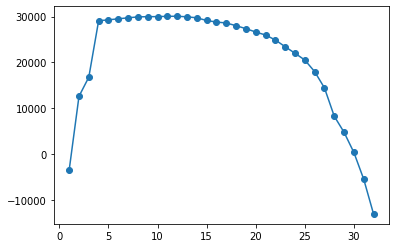

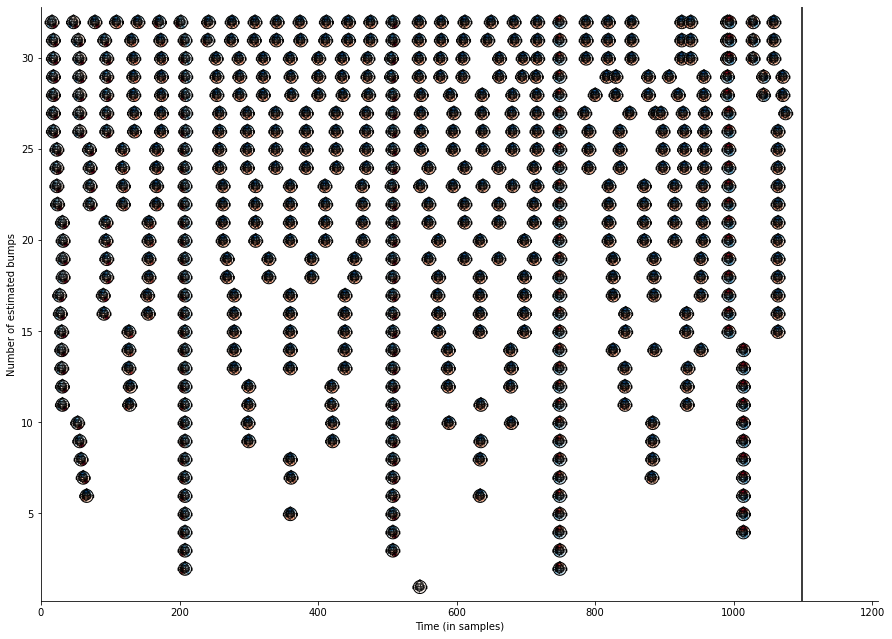

In [9]:
plt.plot(np.arange(1,init.max_bumps+1), iterative_results.likelihoods,'o-')
plt.show()

hsmm.plot_topo_timecourse(init, hsmm_dat, PCs, iterative_results, raw, magnify=2, figsize=(15,10))

### Backward method

In [10]:
bests = init.backward_estimation()
bests

Estimating parameters for 32 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:460: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:466: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 32 bumps model
Estimating parameters for 31 bumps model
Estimating parameters for 31 bumps model
Estimating parameters for 31 bumps model
Estimating parameters for 31 bumps model
Estimating parameters for 31 bumps model
Parameters estimated for 31 bumps model
Estimating parameters for 31 bumps model
Parameters estimated for 31 bumps model
Estimating parameters for 31 bumps model
Parameters estimated for 31 bumps model
Estimating parameters for 31 bumps model
Parameters estimated for 31 bumps model
Estimating parameters for 31 bumps model
Parameters estimated for 31 bumps model
Parameters estimated for 31 bumps model
Parameters estimated for 31 bumps model
Estimating parameters for 31 bumps model
Estimating parameters for 31 bumps model
Estimating parameters for 31 bumps model
Parameters estimated for 31 bumps model
Estimating parameters for 31 bumps model
Parameters estimated for 31 bumps model
Estimating parameters for 31 bumps model
Parameters estimated for 3

Process ForkPoolWorker-36:
Process ForkPoolWorker-37:
Process ForkPoolWorker-40:
Process ForkPoolWorker-38:
Process ForkPoolWorker-39:


KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(init.max_bumps), bests.likelihoods[::-1],'o-')
plt.show()

hsmm.plot_topo_timecourse(init, hsmm_dat, PCs, bests, raw, magnify=2, figsize=(15,10))